## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

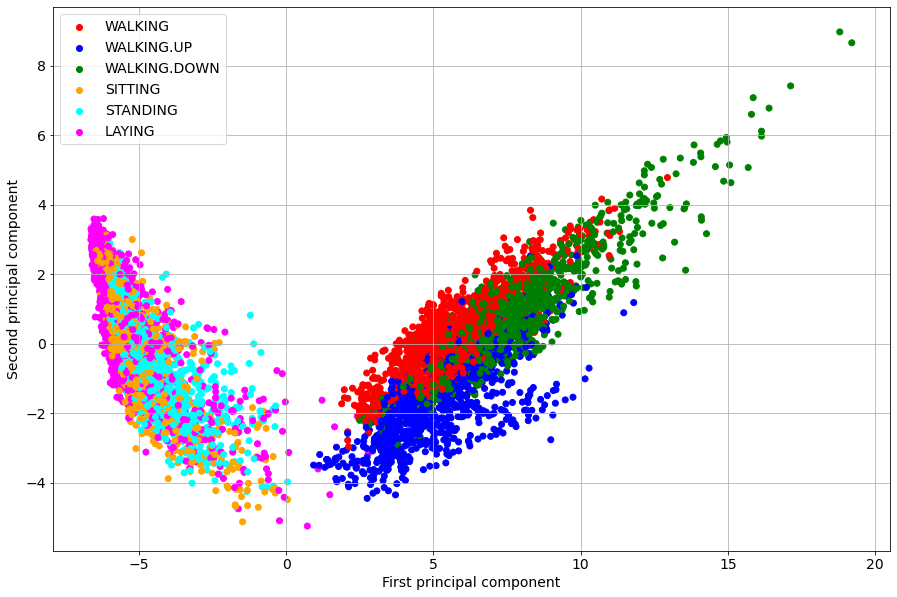

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Experiments start here

In [137]:
import torch
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import clear_output
from torch import cuda

In [138]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [139]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.clip_grad as clip_grad

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import time

In [205]:
N_EPOCHES = 100
BATCH_SIZE = 64
N_LAYERS = 1

In [206]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [207]:
class UCIHAR(Dataset):
    """ UCI HAR dataset
    
        Returns (X, y) sample, where y is one-hot vector
    """
    def __init__(self, X, y, channel_first=True):
        self.X = X
        self.y = y
        
        if channel_first:
            self.X = self.X.transpose(0, 1, 2)  # [Batch, Timesteps, Channels]
            self._n_timesteps = self.X.shape[-1]
            self._n_features = self.X.shape[1]
        else:
            self._n_timesteps = self.X.shape[1]
            self._n_features = self.X.shape[-1]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.long)

In [218]:
train_dataset = UCIHAR(X_train, y_train)
test_dataset = UCIHAR(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [221]:
class LSTMModel(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x, state_h, state_c):
        state = (state_h, state_c)
        lstm_out, state = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out[:, -1])
        next_logp = F.log_softmax(next_logits, dim=1)
        return next_logp, state[0], state[1]
    
    def predict(self, x, state_h, state_c):        
        probs, _, _ = self.forward(x, state_h, state_c)
        return probs.max(1)[1].data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

Проверить detach с state, что пересчет графа происходит из-за того, что мы подаем на backward всё больше частей контекста

Попровобать без инициализации весов

Сравнить с CrossEntropyLoss

Еще раз как работает рнн, что возвращает

In [210]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    print(f'Max accurasy score: {max(val_accuracy)} at {np.argmax(val_accuracy)} epoch')
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    axes[1].plot(np.argmax(val_accuracy), max(val_accuracy), 'ro')

In [217]:
def eval(model, criterion, test_loader):
    ep_val_loss = []
    ep_val_accuracy = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if (len(X_batch)==BATCH_SIZE):

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                state_h, state_c = model.initial_state()

                log_probs, _, _ = model(X_batch, state_h.detach(), state_c.detach())

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                ep_val_loss.append(loss.item())
                y_pred = model.predict(X_batch, state_h.detach(), state_c.detach())
                ep_val_accuracy.append(accuracy_score(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
                
    print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
    print(f"\tvalidation accuracy: {np.mean(ep_val_accuracy):.3f}")
    
    return np.mean(ep_val_loss), np.mean(ep_val_accuracy)

In [233]:
def train_model(model, opt, criterion, train_loader, test_loader, n_epochs=N_EPOCHES, clip_val=15):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    best_accuracy = 0
    
    for epoch in tqdm(range(N_EPOCHES)):        
        start_time = time.time()
            
        model.train(True)
        
        ep_train_loss = []
        
        state_h, state_c = model.initial_state()
        for X_batch, y_batch in train_loader:
            if (len(X_batch)==BATCH_SIZE):
                opt.zero_grad()

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Detach hidden state to avoid recomputing of the graph
                log_probs, state_h, state_c = model(X_batch, state_h.detach(), state_c.detach())

                loss = criterion(log_probs.contiguous(), y_batch[:, 0].contiguous())

                loss.backward()

                clip_grad.clip_grad_norm_(model.parameters(), clip_val)

                opt.step()

                ep_train_loss.append(loss.item())

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        print(f"\t  training loss: {np.mean(ep_train_loss):.6f}")
        
        ep_val_loss, ep_val_accuracy = eval(model, criterion, test_loader)
        
        train_loss_history.append(np.mean(ep_train_loss))
        val_loss_history.append(ep_val_loss)
        val_accuracy_history.append(ep_val_accuracy)
        
        if best_accuracy <= ep_val_accuracy:
            best_accuracy = ep_val_accuracy
            save_checkpoint(f'./Lab2_part4_LSTM/best_lstm_{best_accuracy:.3f}_accuracy.pth', model, opt)
        
        if ((epoch+1)%50 == 0):
            plot_train_process(train_loss_history, val_loss_history, val_accuracy_history)
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [231]:
model = LSTMModel().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.623s
	  training loss: 1.658294
	validation loss: 1.365067
	validation accuracy: 0.456
model saved to ./Lab2_part4_LSTM/best_lstm_0.456_accuracy.pth
Epoch 2 of 100 took 1.222s
	  training loss: 1.228078
	validation loss: 1.237644
	validation accuracy: 0.496
model saved to ./Lab2_part4_LSTM/best_lstm_0.496_accuracy.pth
Epoch 3 of 100 took 1.100s
	  training loss: 1.138698
	validation loss: 1.121087
	validation accuracy: 0.519
model saved to ./Lab2_part4_LSTM/best_lstm_0.519_accuracy.pth
Epoch 4 of 100 took 0.953s
	  training loss: 0.977690
	validation loss: 1.042169
	validation accuracy: 0.583
model saved to ./Lab2_part4_LSTM/best_lstm_0.583_accuracy.pth
Epoch 5 of 100 took 1.209s
	  training loss: 0.843068
	validation loss: 0.836740
	validation accuracy: 0.652
model saved to ./Lab2_part4_LSTM/best_lstm_0.652_accuracy.pth
Epoch 6 of 100 took 1.115s
	  training loss: 0.761264
	validation loss: 0.822369
	validation accuracy: 0.658
model saved to ./Lab2_part4_LSTM/bes

Epoch 62 of 100 took 1.855s
	  training loss: 0.139995
	validation loss: 0.354302
	validation accuracy: 0.882
Epoch 63 of 100 took 1.863s
	  training loss: 0.133995
	validation loss: 0.369146
	validation accuracy: 0.885
Epoch 64 of 100 took 1.681s
	  training loss: 0.132400
	validation loss: 0.315472
	validation accuracy: 0.898
model saved to ./Lab2_part4_LSTM/best_lstm_0.898_accuracy.pth
Epoch 65 of 100 took 2.100s
	  training loss: 0.128673
	validation loss: 0.348358
	validation accuracy: 0.886
Epoch 66 of 100 took 1.842s
	  training loss: 0.139475
	validation loss: 0.349538
	validation accuracy: 0.901
model saved to ./Lab2_part4_LSTM/best_lstm_0.901_accuracy.pth
Epoch 67 of 100 took 2.093s
	  training loss: 0.140246
	validation loss: 0.326002
	validation accuracy: 0.891
Epoch 68 of 100 took 2.001s
	  training loss: 0.136478
	validation loss: 0.432192
	validation accuracy: 0.893
Epoch 69 of 100 took 1.983s
	  training loss: 0.111209
	validation loss: 0.406009
	validation accuracy: 0.

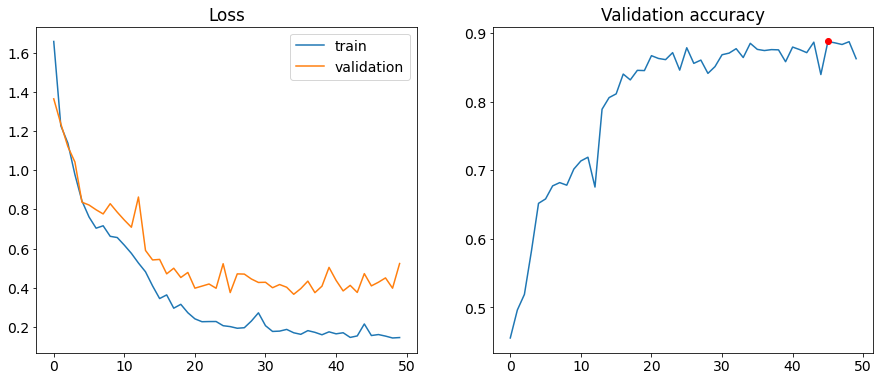

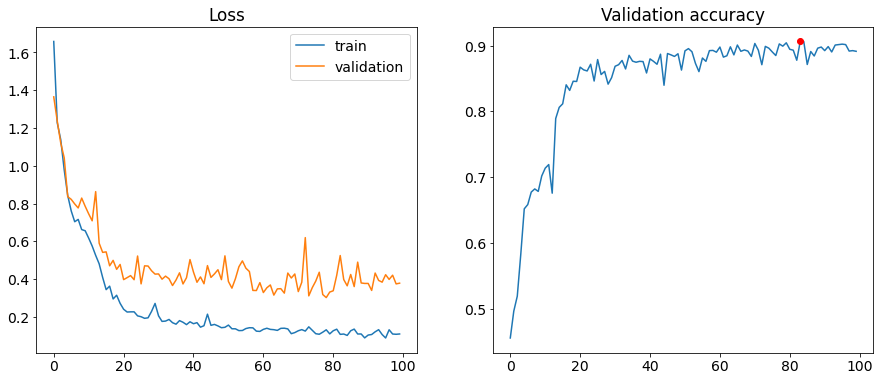

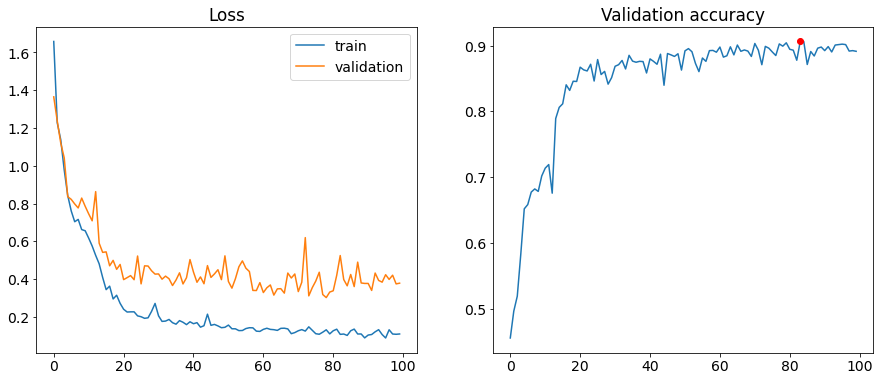

In [232]:
train_loss, val_loss, val_accuracy = train_model(model, opt, criterion, train_dataloader, test_dataloader, 100, 5)

#### Оно работает, но давайте попробуем несколько вещей

1) Будем брать не последний выход из LSTM, а последний после линейного преобразования

*Итог:* Если брать последний выход через прогон после softmax, получается что-то крайне неустойчивое, однако если брать последний после прогона линейного рпеобразования, то разница заключается лишь во времени вычисления

In [238]:
class LSTMModelTest(nn.Module):
    def __init__(self, n_input=9, n_hidden=n_hidden, n_layers=N_LAYERS,
                n_classes=n_classes, drop_prod=0):
        super(self.__class__, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.drop_prob = drop_prod
        
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True, dropout=drop_prod)
        self.hid_to_logits = nn.Linear(n_hidden, n_classes)
        self.dropuot = nn.Dropout(drop_prod)
        
        nn.init.xavier_uniform_(self.hid_to_logits.weight)
        nn.init.zeros_(self.hid_to_logits.bias)
    
    def forward(self, x, state_h, state_c):
        state = (state_h, state_c)
        lstm_out, state = self.lstm(x, state)
        next_logits = self.hid_to_logits(lstm_out)
        next_logp = F.log_softmax(next_logits[:, -1], dim=1)
        return next_logp, state[0], state[1]
    
    def predict(self, x, state_h, state_c):        
        probs, _, _ = self.forward(x, state_h, state_c)
        return probs.max(1)[1].data
        
    def initial_state(self, batch_size=BATCH_SIZE):
        return (torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.n_hidden, requires_grad=True).to(device)
               )

In [239]:
model = LSTMModelTest().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100 took 1.787s
	  training loss: 1.636929
	validation loss: 1.406488
	validation accuracy: 0.380
model saved to ./Lab2_part4_LSTM/best_lstm_0.380_accuracy.pth
Epoch 2 of 100 took 2.011s
	  training loss: 1.329362
	validation loss: 1.278184
	validation accuracy: 0.507
model saved to ./Lab2_part4_LSTM/best_lstm_0.507_accuracy.pth
Epoch 3 of 100 took 1.750s
	  training loss: 1.200917
	validation loss: 1.134471
	validation accuracy: 0.527
model saved to ./Lab2_part4_LSTM/best_lstm_0.527_accuracy.pth
Epoch 4 of 100 took 1.763s
	  training loss: 1.000512
	validation loss: 1.005191
	validation accuracy: 0.545
model saved to ./Lab2_part4_LSTM/best_lstm_0.545_accuracy.pth
Epoch 5 of 100 took 2.182s
	  training loss: 0.873197
	validation loss: 0.980353
	validation accuracy: 0.568
model saved to ./Lab2_part4_LSTM/best_lstm_0.568_accuracy.pth
Epoch 6 of 100 took 2.050s
	  training loss: 0.845154
	validation loss: 0.935688
	validation accuracy: 0.575
model saved to ./Lab2_part4_LSTM/bes

	validation loss: 0.318553
	validation accuracy: 0.897
Epoch 61 of 100 took 0.914s
	  training loss: 0.127040
	validation loss: 0.366900
	validation accuracy: 0.894
Epoch 62 of 100 took 1.997s
	  training loss: 0.108223
	validation loss: 0.366265
	validation accuracy: 0.891
Epoch 63 of 100 took 0.953s
	  training loss: 0.128428
	validation loss: 0.319865
	validation accuracy: 0.901
Epoch 64 of 100 took 0.919s
	  training loss: 0.112532
	validation loss: 0.384966
	validation accuracy: 0.878
Epoch 65 of 100 took 1.542s
	  training loss: 0.121339
	validation loss: 0.367050
	validation accuracy: 0.890
Epoch 66 of 100 took 0.915s
	  training loss: 0.106966
	validation loss: 0.381103
	validation accuracy: 0.887
Epoch 67 of 100 took 1.726s
	  training loss: 0.115324
	validation loss: 0.345620
	validation accuracy: 0.892
Epoch 68 of 100 took 1.053s
	  training loss: 0.095372
	validation loss: 0.367063
	validation accuracy: 0.883
Epoch 69 of 100 took 0.871s
	  training loss: 0.109892
	validatio

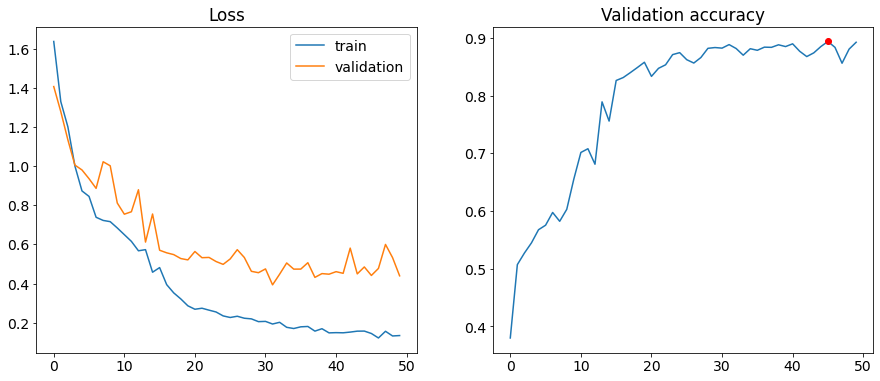

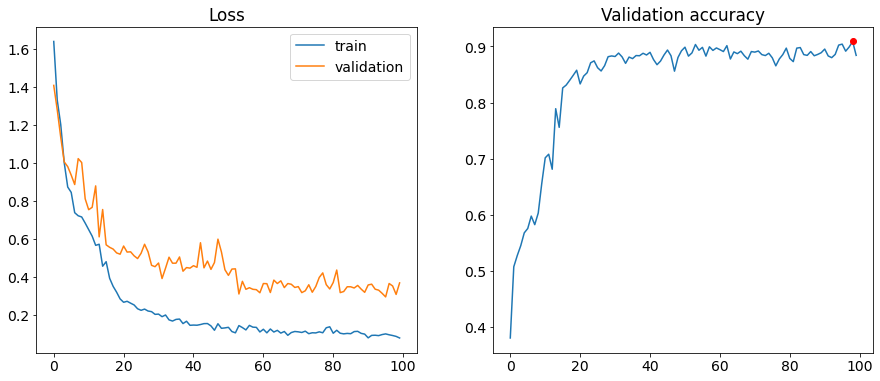

In [240]:
train_loss, val_loss, val_accuracy = train_model(model, opt, criterion, train_dataloader, test_dataloader, 100, 5)

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [107]:
y_pred

tensor([-1.6844, -1.6854, -1.6854, -1.6815, -1.6789], device='cuda:0')

In [ ]:
# Your experiments here

In [557]:
torch.argmax(logits[:, -1], dim=1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')